In [1]:
import pandas as pd

In [2]:
import scanpy as sc

In [14]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
sample2 = sc.read_h5ad('/home/mmigl/notebooks/adata_2_filtered_new.h5ad')
sample2.obs['Sample'] = 'Sample2' 

In [5]:
sample4 = sc.read_h5ad('/home/mmigl/notebooks/adata_4_filtered_new.h5ad')
sample4.obs['Sample'] = 'Sample4' 

In [6]:
merged_adata = sc.concat([sample2, sample4])

In [8]:
def merge(adata):
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.normalize_total(adata) 
    sc.pp.log1p(adata)
    adata.layers["logcounts"] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, layer = 'Counts', flavor = "seurat_v3")
    sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.write('merged_adata_pca.h5ad', adata)
    return adata

In [9]:
merged_adata = merge(merged_adata)

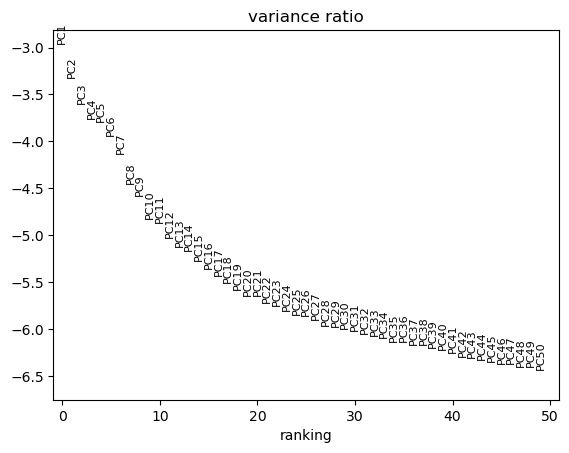

In [11]:
sc.pl.pca_variance_ratio(merged_adata, log=True, n_pcs=50)

In [15]:
sc.pp.neighbors(merged_adata, n_pcs=40)
sc.tl.umap(merged_adata)
sc.tl.leiden(merged_adata, resolution = 0.5)
sc.write('clustered_merged_adata.h5ad', merged_adata)

In [ ]:
#Batch aware feature selection

In [21]:
sc.pp.highly_variable_genes(merged_adata, n_top_genes=2000, layer = 'Counts', flavor = "seurat_v3", batch_key = 'Sample')

In [22]:
merged_adata.var["highly_variable_nbatches"].value_counts()

highly_variable_nbatches
0    12351
1     1636
2     1182
Name: count, dtype: int64

In [24]:
merged_adata_hvg = merged_adata[:, merged_adata.var["highly_variable"]].copy()

In [136]:
#sc.write('mered_adata_unintegrated.h5ad', merged_adata_hvg)

In [ ]:
#SCVI for sample integration

In [25]:
import scvi

In [26]:
merged_adata_scvi = merged_adata_hvg.copy()

In [36]:
import numpy as np
def merge_scvi(adata):
    scvi.model.SCVI.setup_anndata(adata, layer = "Counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['total_counts', 'total_counts_mt'])
    model = scvi.model.SCVI(adata)
    model.train()
    model.save(model_path)
    adata.obsm['X_scVI'] = model.get_latent_representation()
    adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
    sc.pp.neighbors(adata, use_rep = 'X_scVI')
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution = 0.5)
    adata.layers['scvi_normalized'] = np.log1p(adata.layers['scvi_normalized'])
    sc.write('merged_adata_scvi.h5ad', adata)
    return adata

In [37]:
model_path = 'model_scvi_merged/'

In [38]:
merged_adata_scvi = merge_scvi(merged_adata_scvi)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:32<00:00,  4.32it/s, v_num=1, train_loss_step=540, train_loss_epoch=498]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:32<00:00,  4.33it/s, v_num=1, train_loss_step=540, train_loss_epoch=498]


In [39]:
model = scvi.model.SCVI.load(model_path, adata=merged_adata_scvi)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File model_scvi_merged/model.pt already downloaded                                                        


In [ ]:
#Scanorama for integration

In [44]:
import scanorama

In [ ]:
merged_adata_scanorama = merged_adata_hvg.copy()

In [69]:
def merge_scanorama(adata):
    sample_cats = adata.obs.Sample.cat.categories
    scanorama_list = [adata[adata.obs.Sample == b].copy() for b in sample_cats]
    scanorama.integrate_scanpy(scanorama_list)
    adata.obsm["Scanorama"] = np.zeros((adata.shape[0], scanorama_list[0].obsm["X_scanorama"].shape[1]))
    for i, b in enumerate(sample_cats):
        adata.obsm["Scanorama"][adata.obs.Sample == b] = scanorama_list[i].obsm["X_scanorama"]
    sc.write('merged_adata_scanorama.h5ad', adata)
    return adata

In [70]:
merged_adata_scanorama = merge_scanorama(merged_adata_scanorama)

Found 2000 genes among all datasets
[[0.         0.91104869]
 [0.         0.        ]]
Processing datasets (0, 1)


In [ ]:
#Evaluation of model performance

In [95]:
from scib_metrics.benchmark import Benchmarker

In [42]:
batch_key = 'Sample'
label_key = 'leiden'

In [121]:
merged_adata_hvg.obsm['Unintegrated'] = merged_adata_hvg.obsm['X_pca']
merged_adata_hvg.obsm['SCVI'] = merged_adata_scvi.obsm['SCVI'].copy()
merged_adata_hvg.obsm['Scanorama'] = merged_adata_scanorama.obsm['Scanorama'].copy()

In [122]:
merged_adata_hvg

AnnData object with n_obs × n_vars = 3481 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap', 'Unintegrated', 'SCVI', 'Scanorama'
    varm: 'PCs'
    layers: 'Counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [126]:
#sc.write('final_merged_adata.h5ad', merged_adata_hvg)

In [123]:
evaluation = Benchmarker(
    merged_adata_hvg,
    batch_key="Sample",
    label_key="leiden",
    embedding_obsm_keys=["Unintegrated", "SCVI", "Scanorama"],
    n_jobs=1,
)

In [124]:
evaluation.benchmark()

/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:  60%|████████████████████████████▏                  | 6/10 [00:06<00:03,  1.01it/s, Batch correction: kbet_per_label]

INFO     11 consists of a single batch or is too small. Skip.                                                      
INFO     19 consists of a single batch or is too small. Skip.                                                      



Metrics:  70%|██████████████████████████████             | 7/10 [00:07<00:02,  1.23it/s, Batch correction: graph_connectivity]/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:  80%|█████████████████████████████████████▌         | 8/10 [00:08<00:01,  1.23it/s, Batch correction: pcr_comparison]/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Metrics:   0%|                                                                                         | 0/10 [00:00<?, ?it/s]
                                                                                                                          

INFO     11 consists of a single batch or is too small. Skip.                                                      
INFO     19 consists of a single batch or is too small. Skip.                                                      


/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)

Metrics:  70%|██████████████████████████████             | 7/10 [00:03<00:01,  2.23it/s, Batch correction: graph_connectivity]/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|                                                                                         | 0/10 [00:00<?, ?it/s]
                                                                                                                              
Metrics:  60%|████████████████████████████▏                  | 6/10 [00:13<00:07,  1.94s/it, Batch

INFO     11 consists of a single batch or is too small. Skip.                                                      
INFO     19 consists of a single batch or is too small. Skip.                                                      



Metrics:  70%|██████████████████████████████             | 7/10 [00:14<00:04,  1.36s/it, Batch correction: graph_connectivity]/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.67s/it]

                                                                                                                              

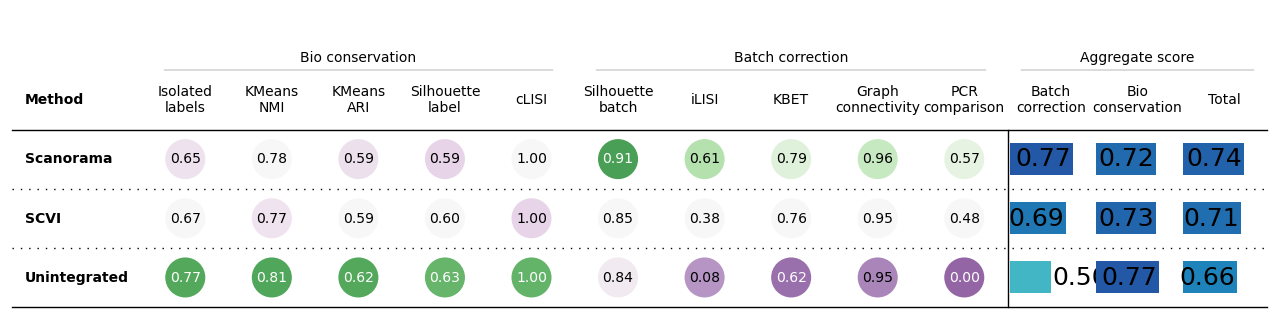

In [125]:
evaluation.plot_results_table(min_max_scale=False)

In [133]:
import joblib

In [134]:
joblib.dump(evaluation, 'evaluation.joblib')

['evaluation.joblib']

In [ ]:
#UMAP

In [127]:
merged_adata_hvg

AnnData object with n_obs × n_vars = 3481 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap', 'Unintegrated', 'SCVI', 'Scanorama'
    varm: 'PCs'
    layers: 'Counts', 'logcounts'
    obsp: 'distances', 'connectivities'

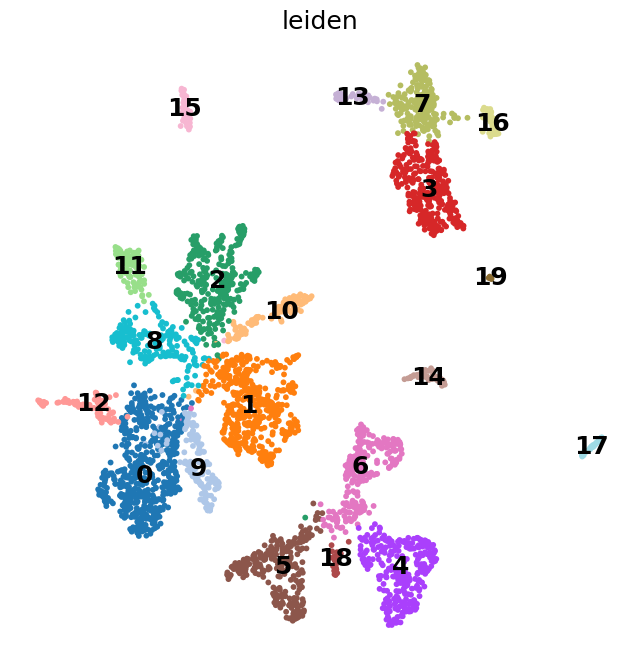

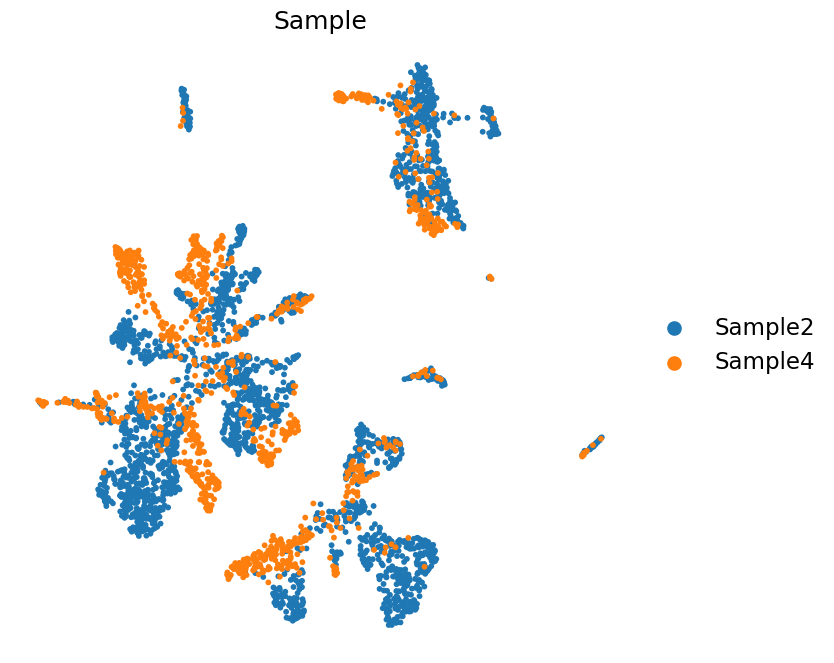

In [130]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(merged_adata_hvg, color = 'leiden', frameon = False, s = 70, legend_loc="on data", alpha=1)
    sc.pl.umap(merged_adata_hvg, color = 'Sample', frameon = False, s = 70, alpha=1)

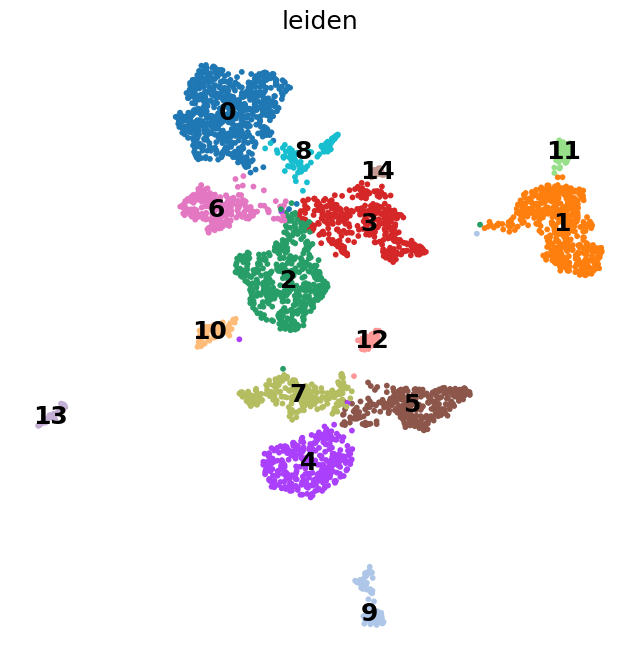

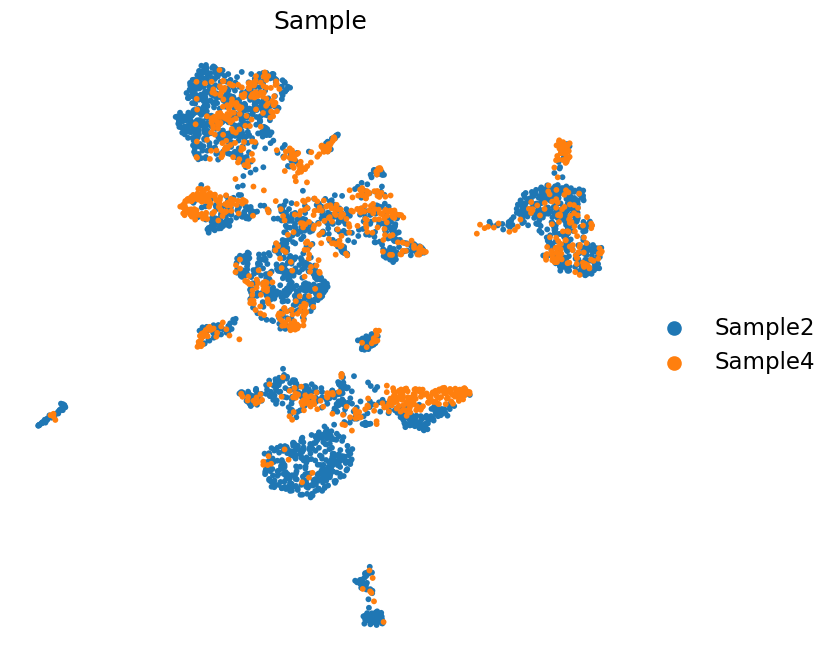

In [131]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(merged_adata_scvi, color = 'leiden', frameon = False, s = 70, legend_loc="on data", alpha=1)
    sc.pl.umap(merged_adata_scvi, color = 'Sample', frameon = False, s = 70, alpha=1)

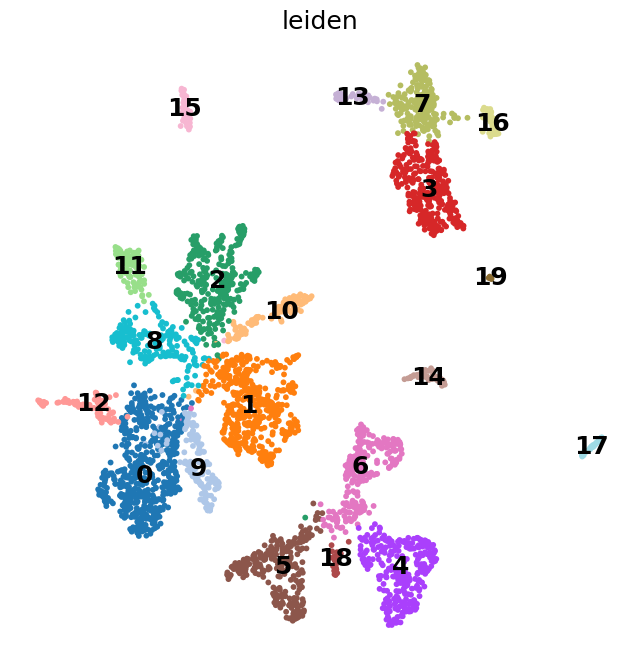

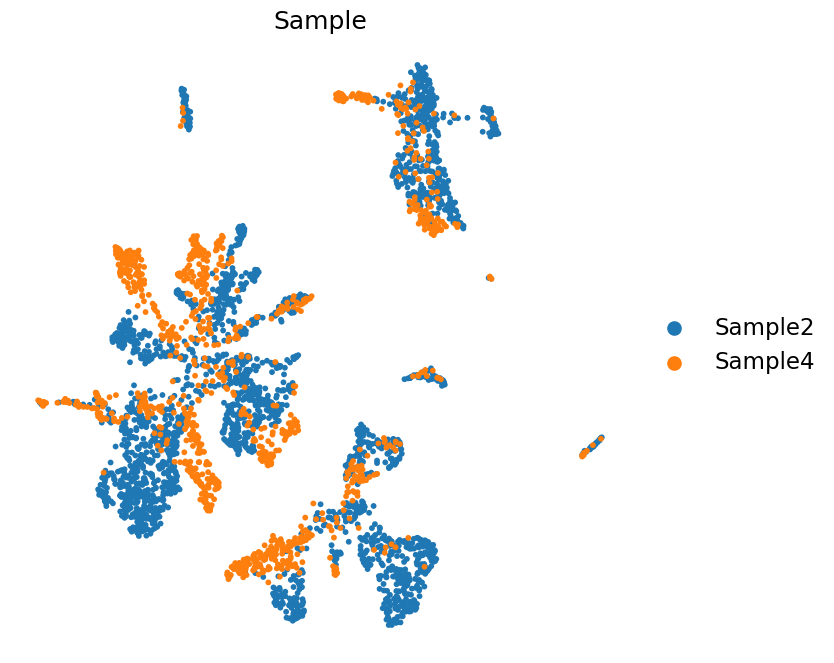

In [132]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(merged_adata_scanorama, color = 'leiden', frameon = False, s = 70, legend_loc="on data", alpha=1)
    sc.pl.umap(merged_adata_scanorama, color = 'Sample', frameon = False, s = 70, alpha=1)

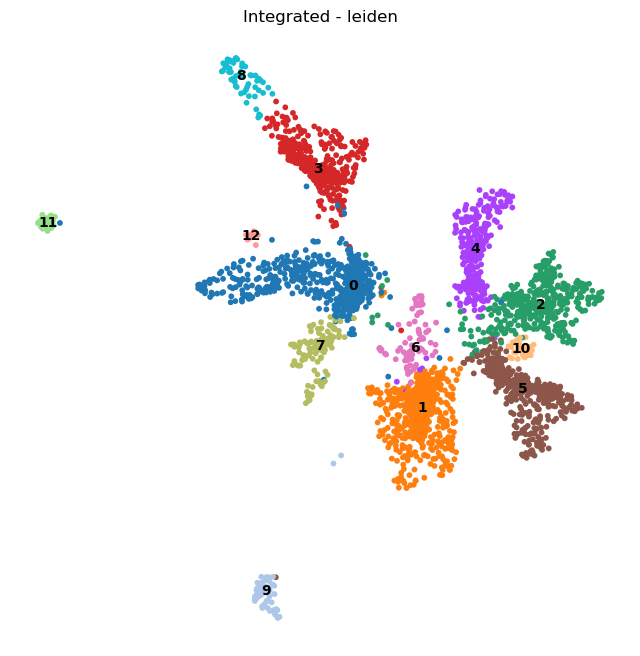

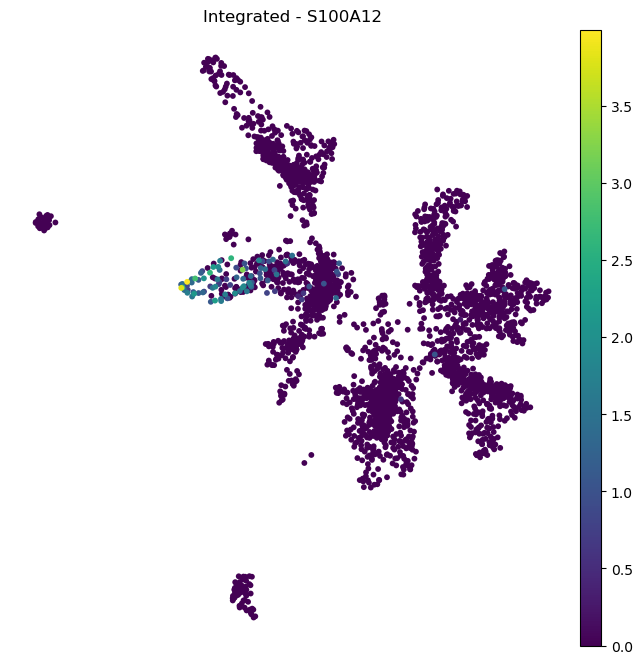

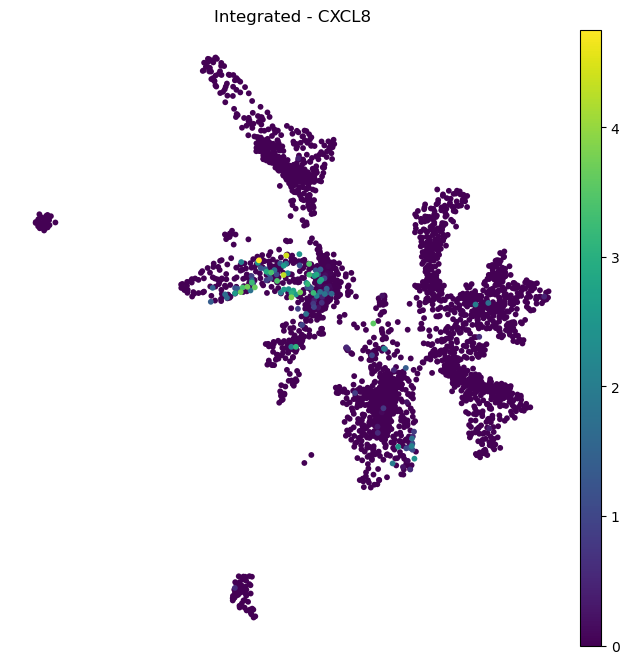

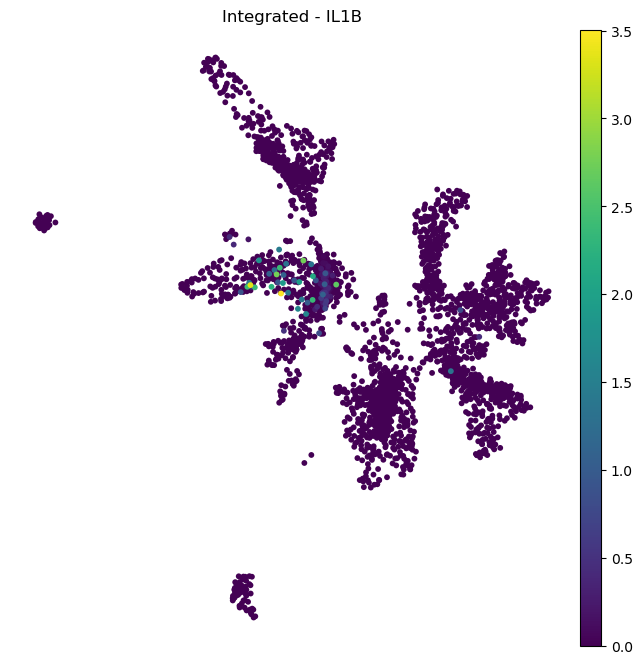

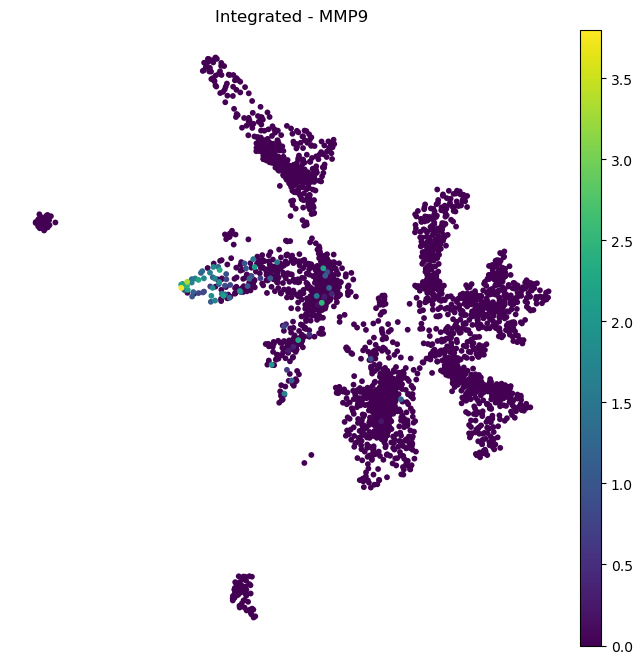

In [94]:
import matplotlib.pyplot as plt
genes_to_plot = ['leiden', 'S100A12', 'CXCL8', 'IL1B', 'MMP9']  #SPP1, VEGFA, CXCR2, IFIT1, ISG15,  
with rc_context({'figure.figsize': (8, 8)}):
    for gene in genes_to_plot:
        sc.pl.umap(merged_adata_1, color=gene, frameon=False, title=f'Integrated - {gene}', s=70, legend_loc="on data", alpha=1)
        plt.show()

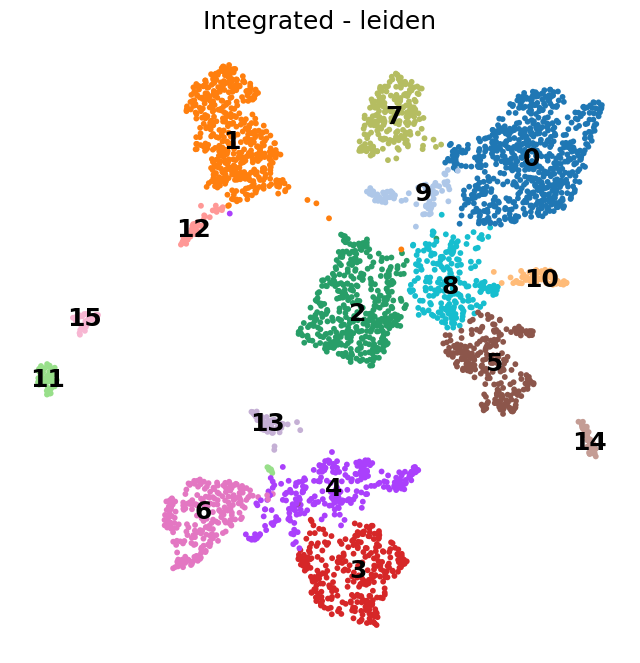

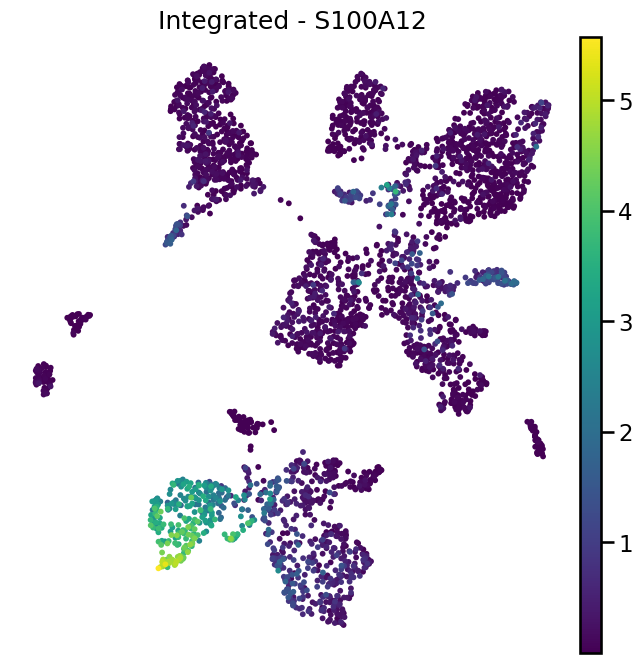

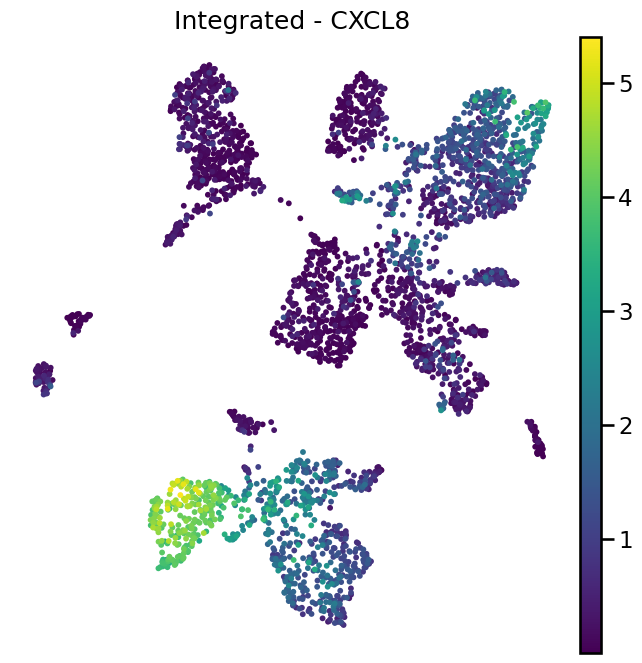

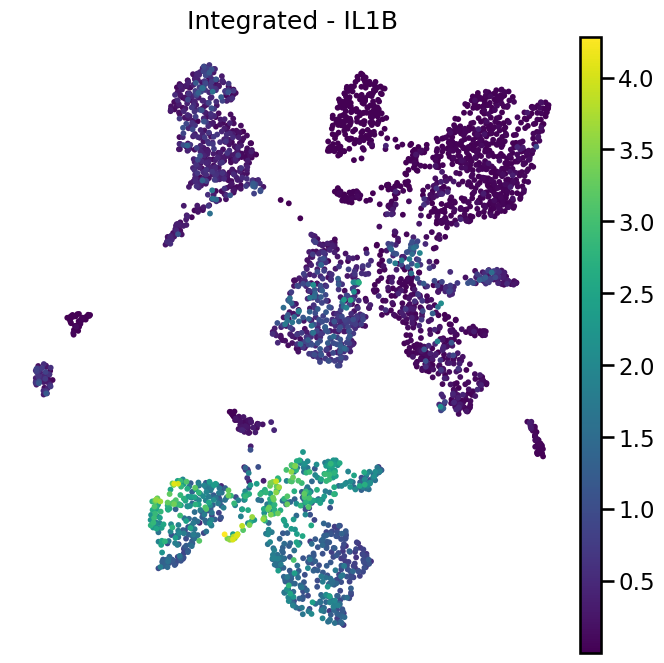

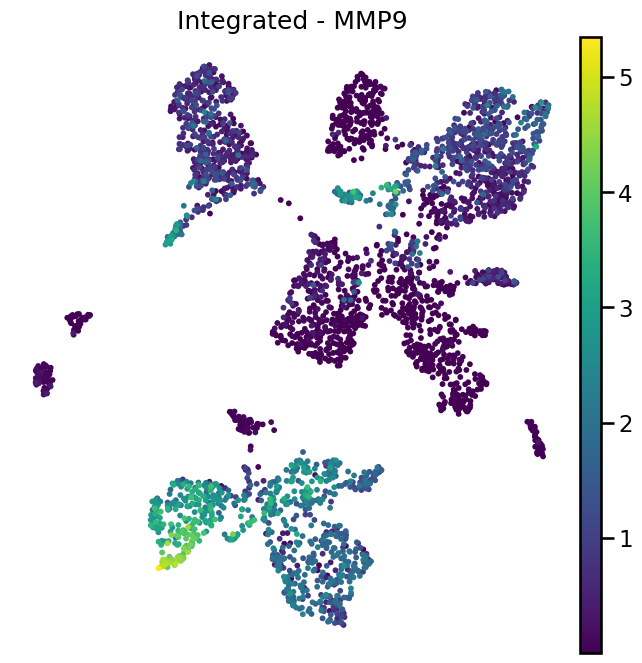

In [149]:
import matplotlib.pyplot as plt
genes_to_plot = ['leiden', 'S100A12', 'CXCL8', 'IL1B', 'MMP9']  
with rc_context({'figure.figsize': (8, 8)}):
    for gene in genes_to_plot:
        sc.pl.umap(merged_adata_scvi, color=gene, frameon=False, title=f'Integrated - {gene}', s=70, legend_loc="on data", alpha=1, layer = 'scvi_normalized')
        plt.show()

<Figure size 1000x1000 with 0 Axes>

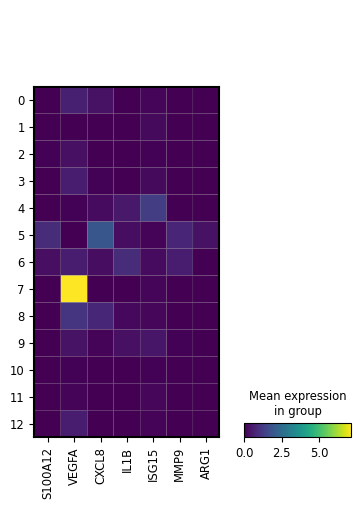

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata, N_markers, groupby='leiden')
plt.show()

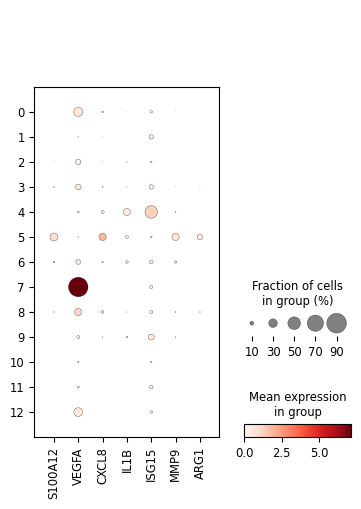

In [28]:
sc.pl.dotplot(adata, N_markers, groupby='leiden')

<Figure size 1000x1000 with 0 Axes>

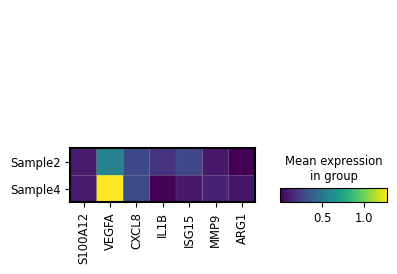

In [29]:
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata, N_markers, groupby='Sample')
plt.show()

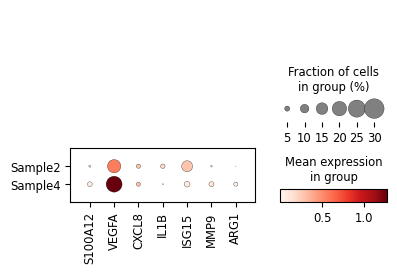

In [30]:
sc.pl.dotplot(adata, N_markers, groupby='Sample')

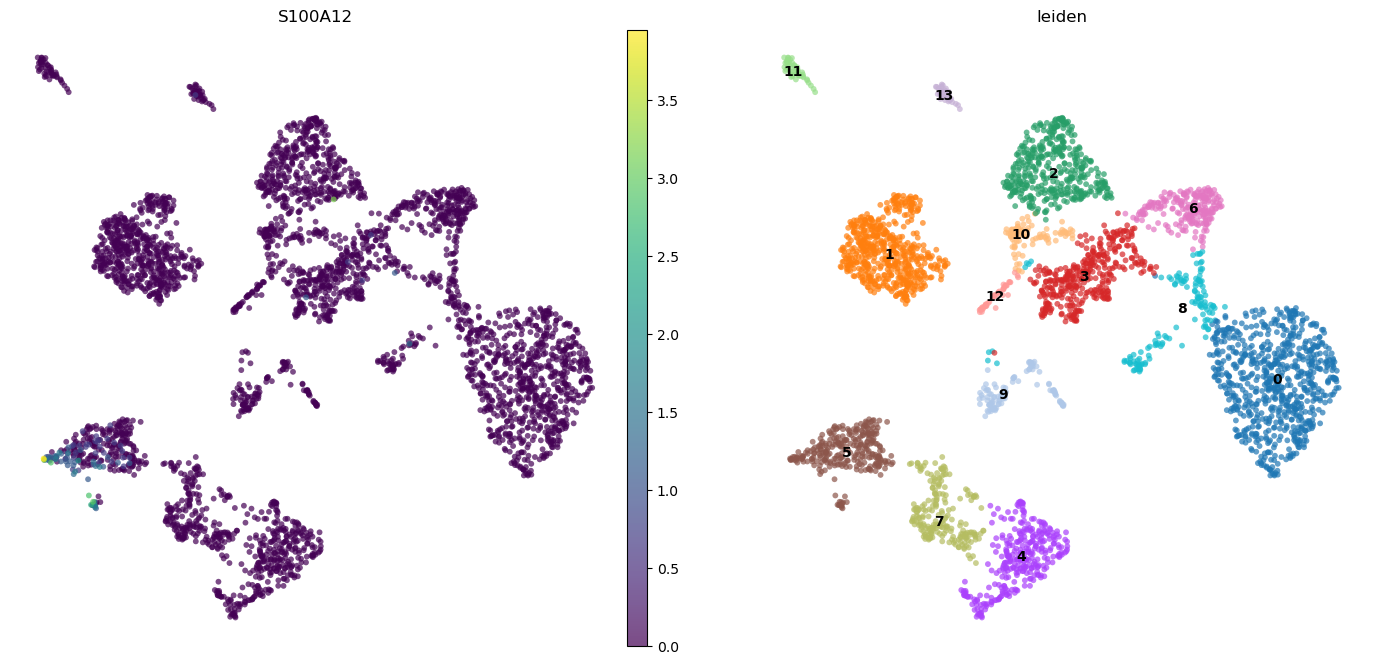

In [53]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['S100A12','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')

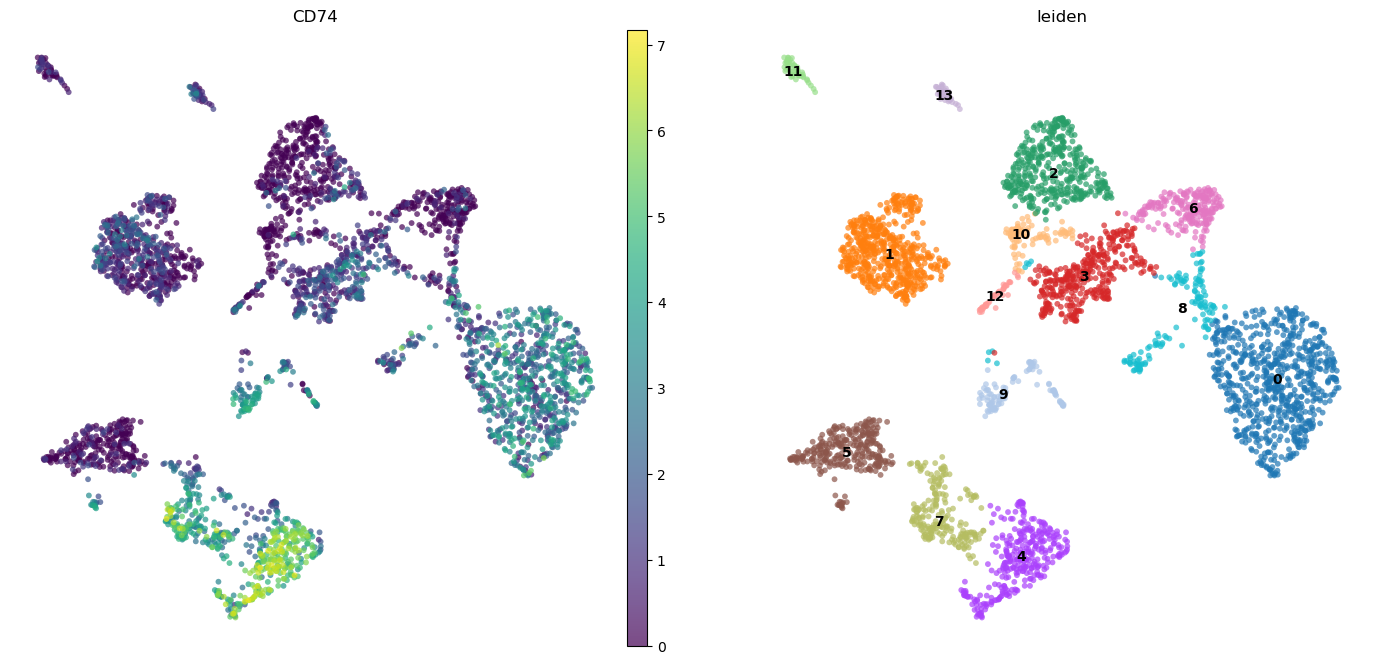

In [54]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['CD74','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p') 

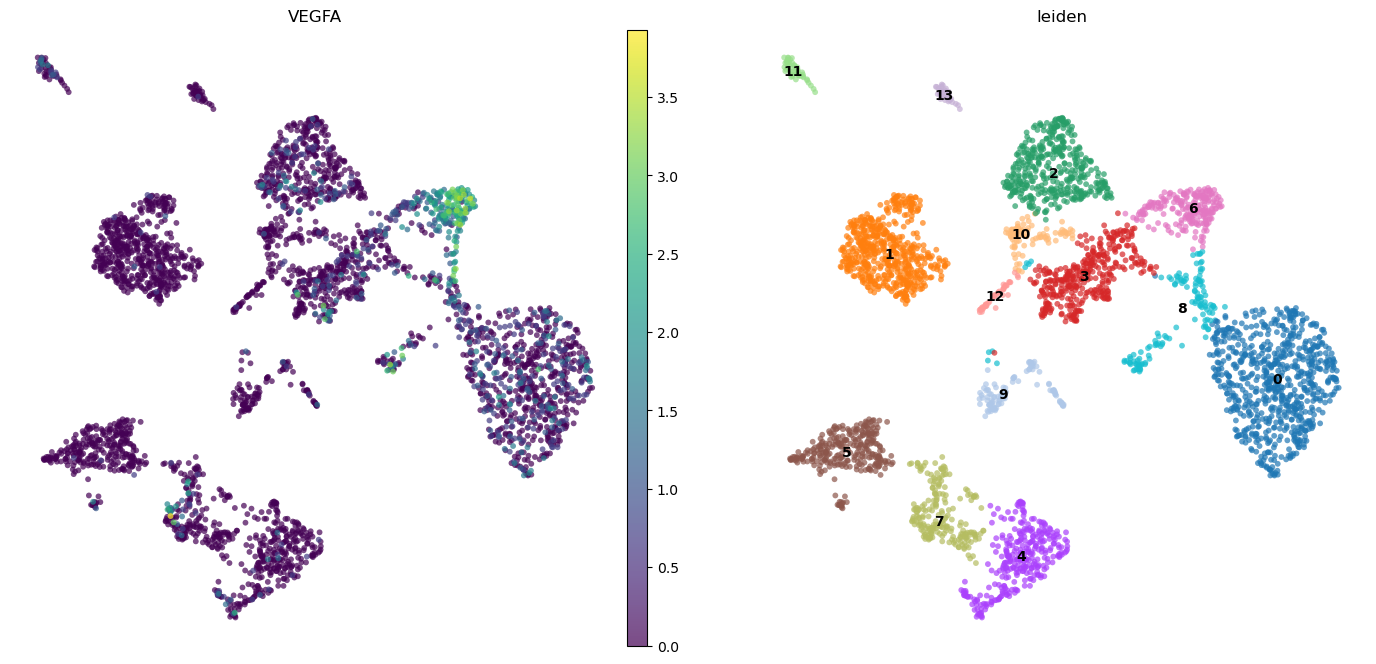

In [55]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['VEGFA','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')  #SPP1 Not Found

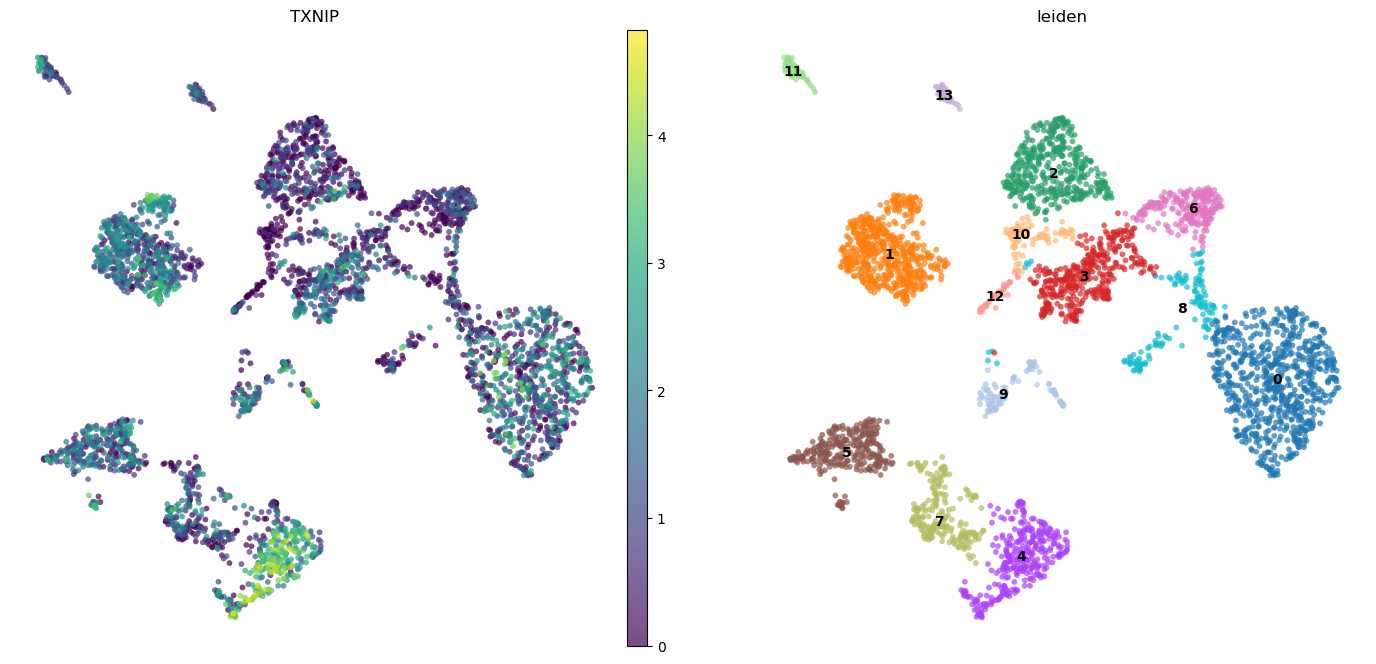

In [56]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['TXNIP','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')

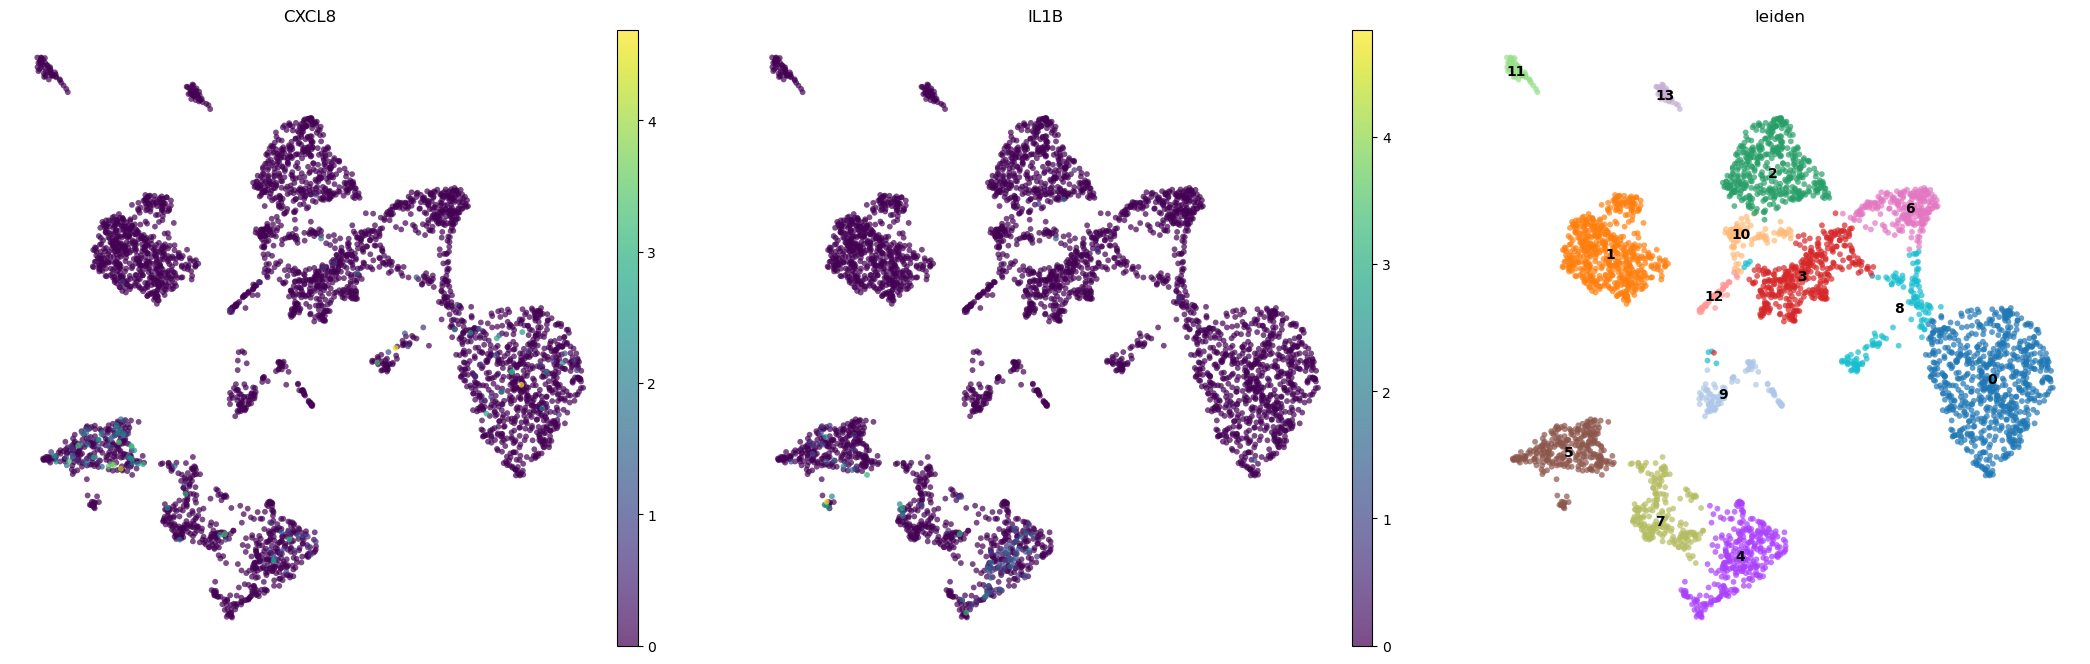

In [57]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['CXCL8','IL1B','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')

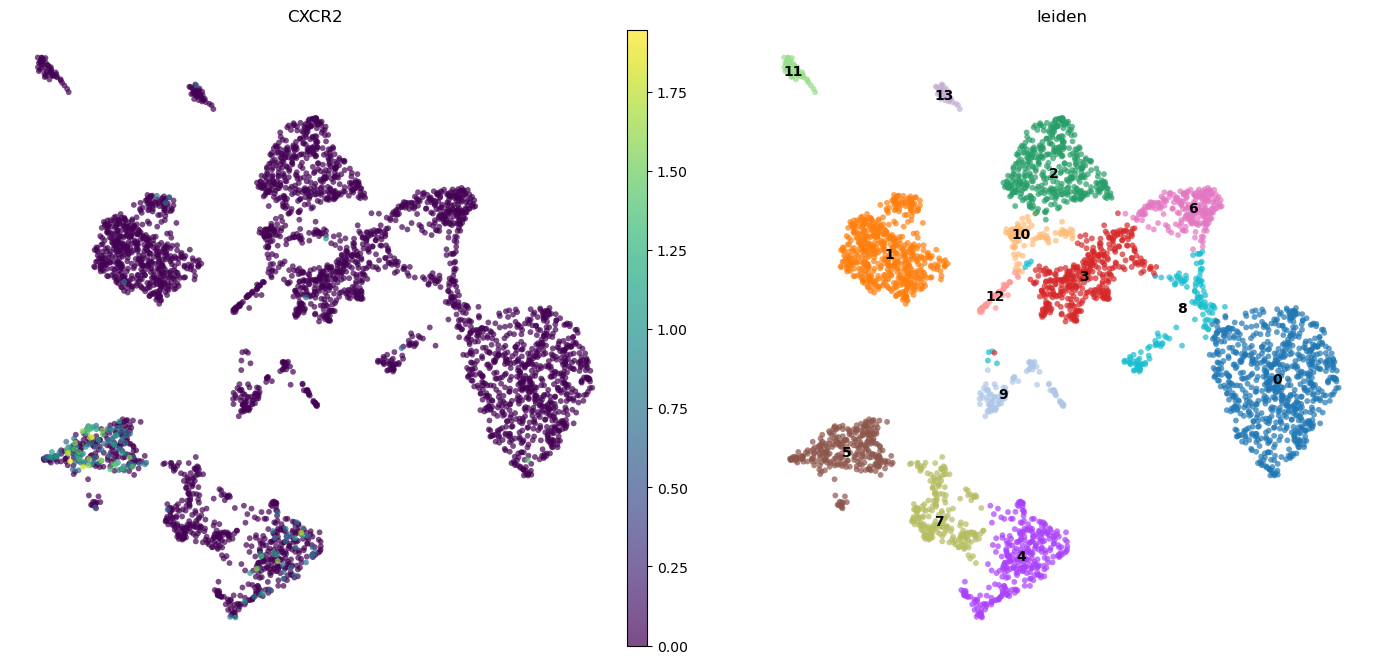

In [58]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['CXCR2','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')   

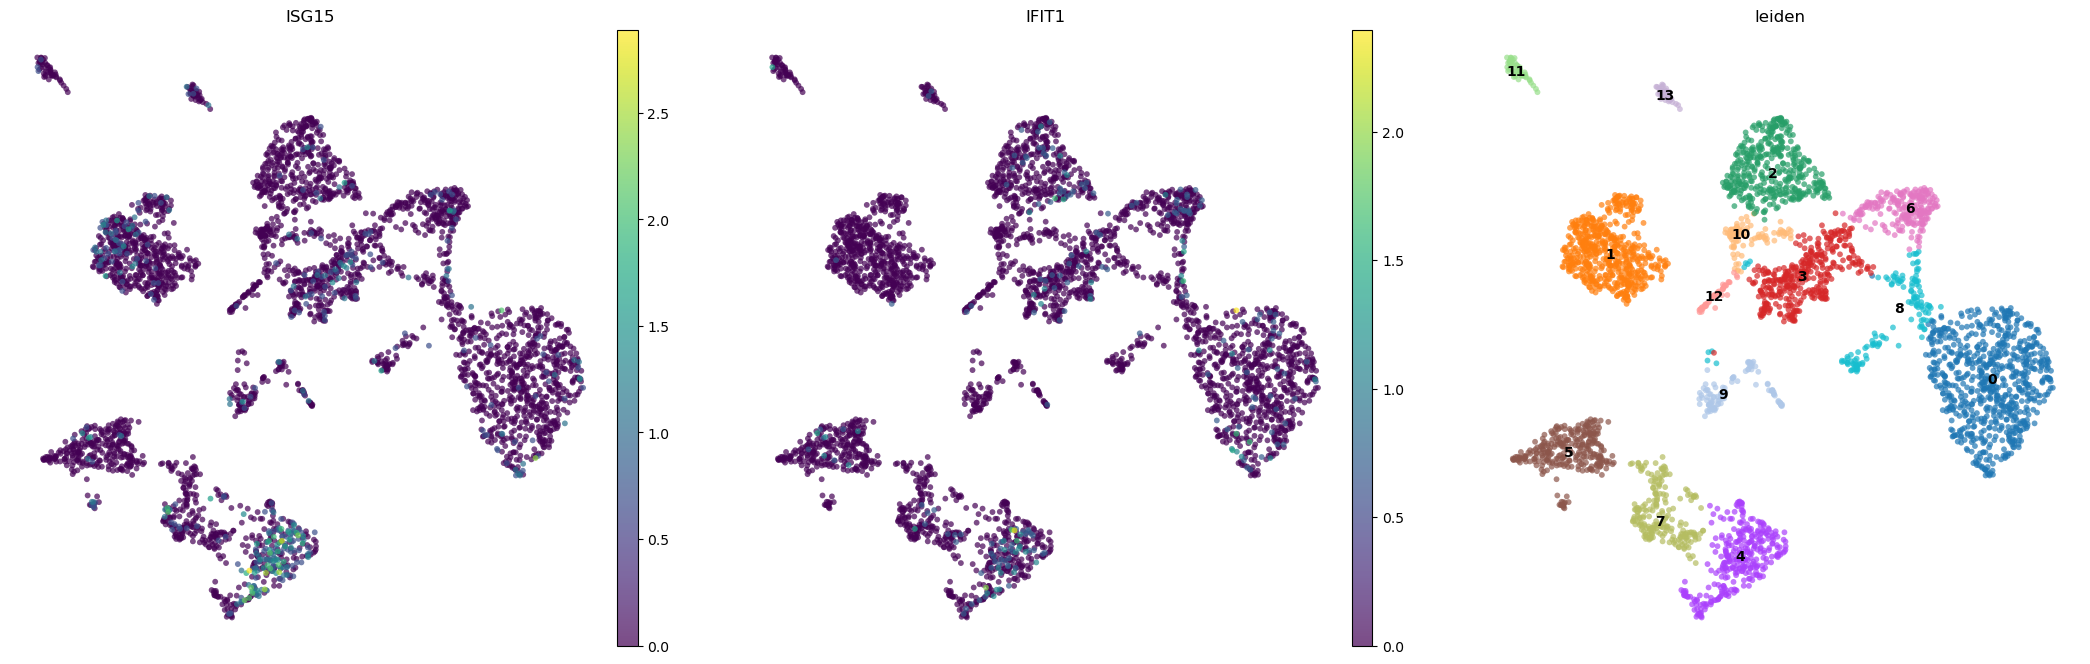

In [59]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['ISG15','IFIT1','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')  

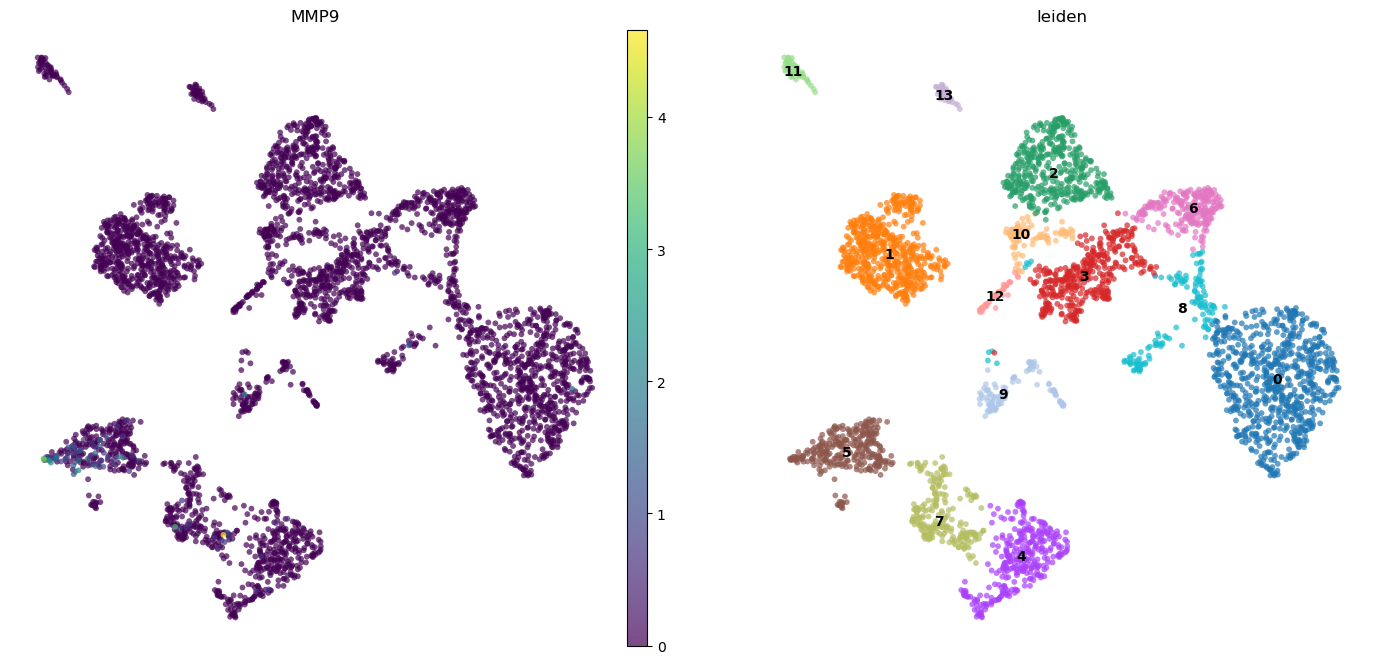

In [60]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['MMP9','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')

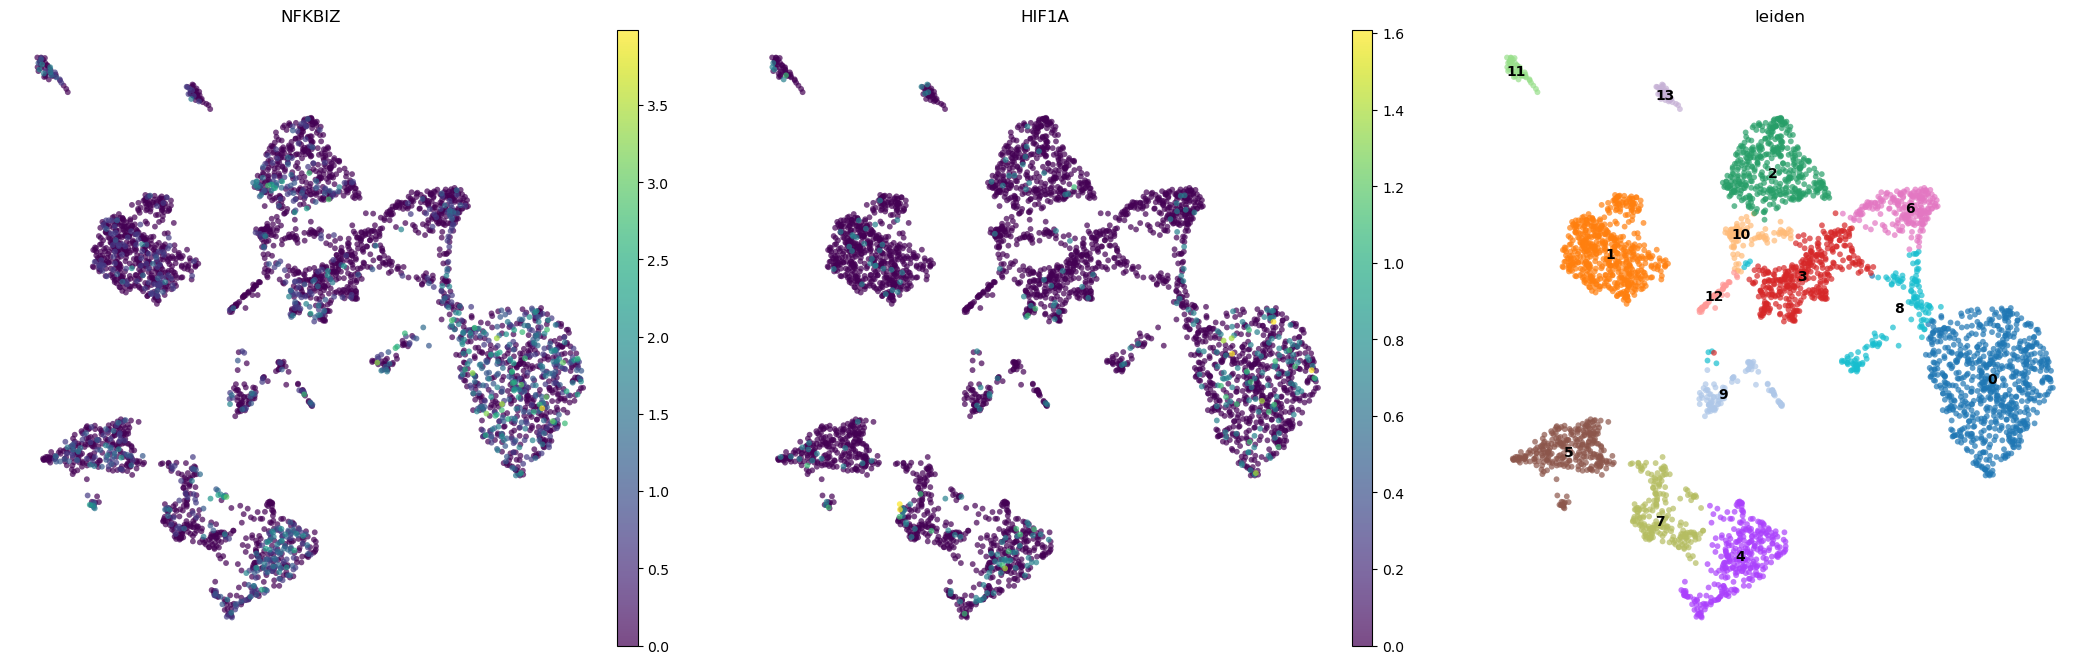

In [61]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['NFKBIZ','HIF1A','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')  

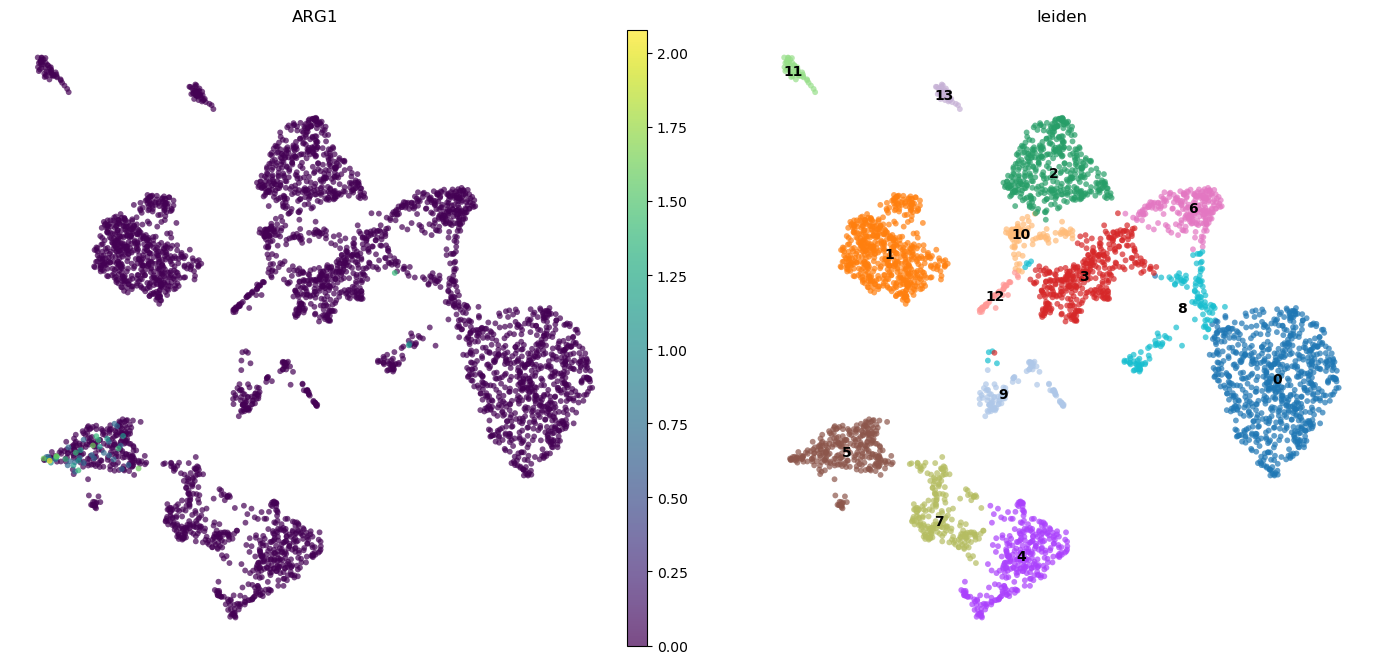

In [62]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_, color = ['ARG1','leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.7, layer = 'log1p')

In [63]:
N_markers_ = ['S100A12', 'CD74', 'VEGFA', 'TXNIP', 'CXCL8', 'IL1B', 'CXCR2', 'ISG15', 'IFIT1', 'MMP9', 'NFKBIZ', 'HIF1A', 'ARG1']

<Figure size 1000x1000 with 0 Axes>

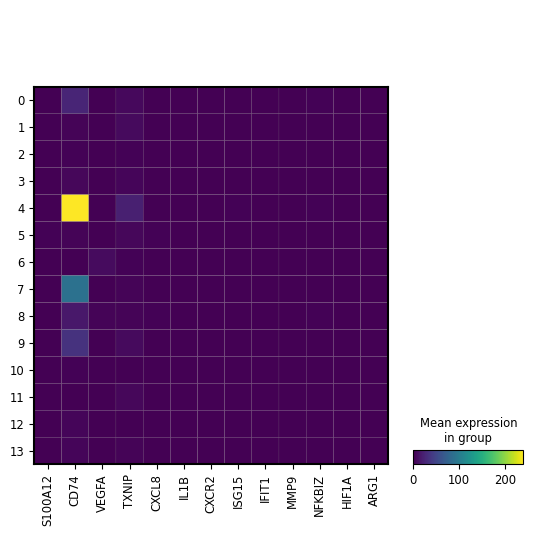

In [64]:
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata_, N_markers_, groupby='leiden')
plt.show()

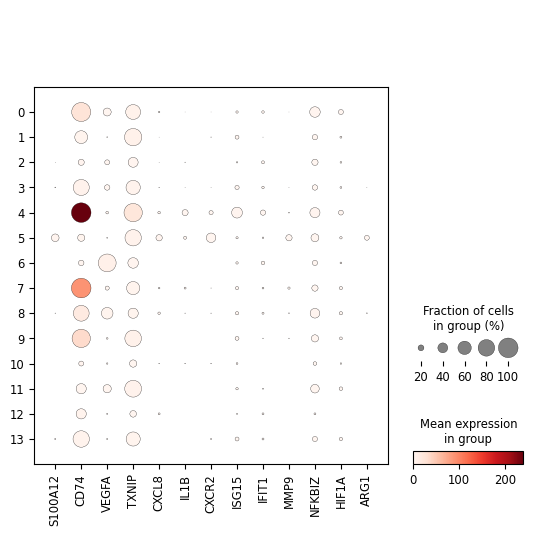

In [65]:
sc.pl.dotplot(adata_, N_markers_, groupby='leiden')

<Figure size 1000x1000 with 0 Axes>

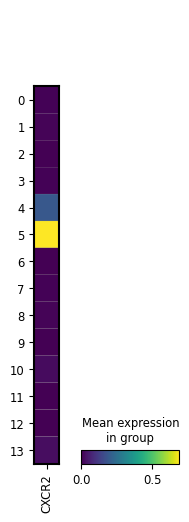

In [66]:
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata_, 'CXCR2', groupby='leiden')
plt.show()

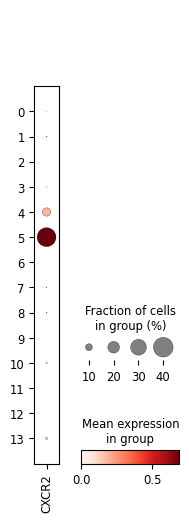

In [67]:
sc.pl.dotplot(adata_, 'CXCR2', groupby='leiden')

<Figure size 1000x1000 with 0 Axes>

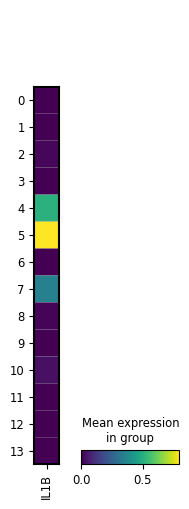

In [68]:
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata_, 'IL1B', groupby='leiden')
plt.show()

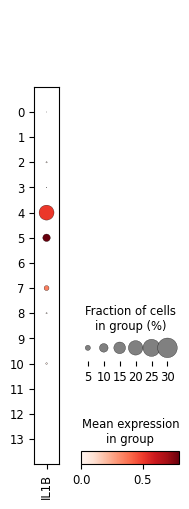

In [69]:
sc.pl.dotplot(adata_, 'IL1B', groupby='leiden')

<Figure size 1000x1000 with 0 Axes>

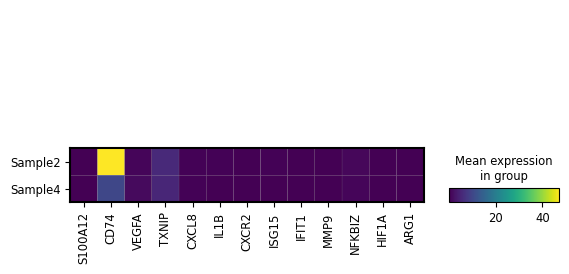

In [70]:
plt.figure(figsize=(10, 10))
sc.pl.matrixplot(adata_, N_markers_, groupby='Sample')
plt.show()

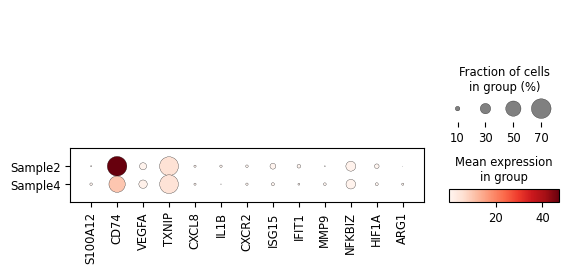

In [71]:
sc.pl.dotplot(adata_, N_markers_, groupby='Sample')